# BT4016 Final Project

## Import Libraries

In [49]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
import math
from math import sqrt, exp
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
def get_data_for_multiple_stocks(tickers,start_date="2020-02-01",end_date="2022-02-01"):
    # initialise output dataframe
    returns_df = pd.DataFrame()
    stocks = dict()
    # loop through all the tickers
    for ticker in tickers: 
        format="%Y-%m-%d"
        s = yf.download(ticker, dt.datetime.strptime(start_date, format), dt.datetime.strptime(end_date, format))

        # append to returns_df
        returns_df[ticker+'_adj_close'] = s['Adj Close']

        # Transform Date from integer to date type
    # returns_df = returns_df.reset_index() #to be able to access it as a pandas column rather than index
    # returns_df['Date'] = pd.to_datetime(returns_df['Date'], infer_datetime_format=True)
    
    # rename columns
    returns_df.rename(columns={"BTC-USD_adj_close": "BTC_close", \
                   "ETH-USD_adj_close": "ETH_close", \
                    "DOGE-USD_adj_close": "DOGE_close", \
                    "MATIC-USD_adj_close": "MATIC_close"}, inplace=True)
    
    returns_df['BTC_log_return'] = np.log(returns_df['BTC_close'] / returns_df['BTC_close'].shift(1))
    returns_df['ETH_log_return'] = np.log(returns_df['ETH_close'] / returns_df['ETH_close'].shift(1))
    returns_df['DOGE_log_return'] = np.log(returns_df['DOGE_close'] / returns_df['DOGE_close'].shift(1))
    returns_df['MATIC_log_return'] = np.log(returns_df['MATIC_close'] / returns_df['MATIC_close'].shift(1))

    # skip the first row (that will be NA)
    # and fill other NA values by 0 in case there are trading halts on specific days
    returns_df = returns_df.iloc[1:].fillna(0)

    return returns_df

Since in practice, the risk-free rate is commonly considered to equal to the interest paid on a 3-month government Treasury Bills, generally the safest investment an investor can make, we decided to download the daily price of the US government Treasury Bills.

Refer from: [Risk free rate](https://corporatefinanceinstitute.com/resources/valuation/risk-free-rate/)

In [51]:
tickers = ["BTC-USD", "ETH-USD", "DOGE-USD", "MATIC-USD"]
start_date = "2020-02-01"
end_date = "2022-02-01"
np.random.seed(4016)
cmap = {"BTC": np.random.rand(3,),
        "ETH": np.random.rand(3,),
        "DOGE": np.random.rand(3,),
        "MATIC": np.random.rand(3,)}

df = get_data_for_multiple_stocks(tickers, start_date, end_date)
df.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,BTC_close,ETH_close,DOGE_close,MATIC_close,BTC_log_return,ETH_log_return,DOGE_log_return,MATIC_log_return
Date,,,,,,,,
2020-02-02,9344.365234,188.617538,0.002468,0.019115,-0.005178,0.026559,0.018814,0.041880
2020-02-03,9293.521484,189.865067,0.002440,0.022086,-0.005456,0.006592,-0.011410,0.144471
2020-02-04,9180.962891,189.250595,0.002503,0.021129,-0.012185,-0.003242,0.025492,-0.044297
2020-02-05,9613.423828,204.230240,0.002582,0.021433,0.046028,0.076176,0.031074,0.014285
2020-02-06,9729.801758,212.339081,0.002653,0.024459,0.012033,0.038936,0.027127,0.132067


## Question 1

Text(0.5, 1.0, 'Asset Correlations')

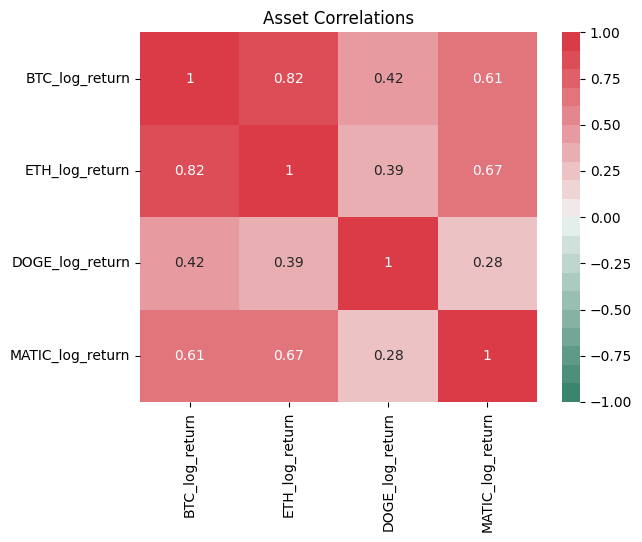

In [52]:
corr = df[["BTC_log_return", "ETH_log_return", "DOGE_log_return", "MATIC_log_return"]].corr()
sns.heatmap(corr, cmap=sns.diverging_palette(160, 10, n = 20), annot=True, vmin=-1, vmax=1)
plt.title("Asset Correlations")

Here, we observe that `DOGE` has the weakest correlation with the other crypto assets. We want to select assets with low correlation to reap the benefits from diversification. If we use assets with very high correlation (e.g. 0.9), there will barely be any diversification benefits and we may run into issues in subsequent optimization.

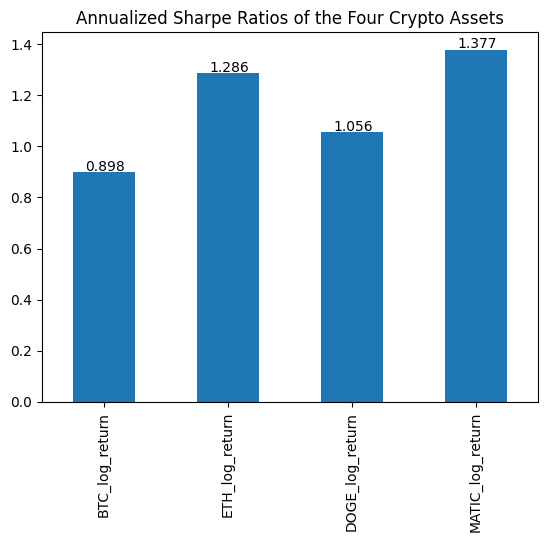

In [53]:
df_return = df[["BTC_log_return", "ETH_log_return", "DOGE_log_return", "MATIC_log_return"]]
mean_daily_returns = df_return.mean()
std_daily_returns = df_return.std()

annualized_mean_returns = mean_daily_returns * 365
annualized_std_returns = std_daily_returns * np.sqrt(365)
sharpe_ratios = round((annualized_mean_returns) / annualized_std_returns, 3)

# Plot the bar chart
ax = sharpe_ratios.plot(kind='bar', title='Annualized Sharpe Ratios of the Four Crypto Assets')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width()/5, p.get_height() * 1.005))

Looking at the bar chart, it is evident that `MATIC` has the highest Sharpe Ratio of 1.377 (rounded to 3 decimal places), followed by `ETH` which has a Sharpe Ratio of 1.286. `DOGE` has a Sharpe Ratio of 1.056, while `BTC` has the lowest Sharpe Ratio of 0.898.

The Sharpe ratio is a measure of risk-adjusted return, and a higher value implies that an investment is generating higher returns relative to the risk taken on. Therefore, the statement implies that `MATIC` has the highest risk-adjusted return among the four cryptocurrencies, followed by `ETH`, `DOGE`, and finally `BTC`.

## Question 2

In order to compute the varying weights for each stock in each day, we decided to take *previous 1 year's* records, i.e. 365-day records as the length of the rolling window to compute the weight of each asset for today.

In [54]:
import cvxpy as cvx

In [55]:
# shifted 1 year earlier than the problem's specified date
start_date = "2019-02-01"
end_date = "2022-02-02"

df2 = get_data_for_multiple_stocks(tickers, start_date, end_date)
df2.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,BTC_close,ETH_close,DOGE_close,MATIC_close,BTC_log_return,ETH_log_return,DOGE_log_return,MATIC_log_return
Date,,,,,,,,
2019-02-02,3521.060791,110.430260,0.001936,0.0,0.009449,0.025873,0.010384,0.0
2019-02-03,3464.013428,107.492668,0.001904,0.0,-0.016334,-0.026962,-0.016667,0.0
2019-02-04,3459.154053,107.821602,0.001896,0.0,-0.001404,0.003055,-0.004211,0.0
2019-02-05,3466.357422,107.443520,0.001888,0.0,0.002080,-0.003513,-0.004228,0.0
2019-02-06,3413.767822,104.919289,0.001866,0.0,-0.015288,-0.023774,-0.011721,0.0


In [56]:
df_return = df2[["BTC_log_return", "ETH_log_return", "DOGE_log_return", "MATIC_log_return"]]
simple_returns = np.exp(df_return) -1
simple_returns.rename(columns={"BTC_log_return": "BTC_return", \
                   "ETH_log_return": "ETH_return", \
                    "DOGE_log_return": "DOGE_return", \
                    "MATIC_log_return": "MATIC_return"}, inplace=True)
simple_returns

,BTC_return,ETH_return,DOGE_return,MATIC_return
Date,,,,
2019-02-02,0.009494,0.026210,0.010438,0.000000
2019-02-03,-0.016202,-0.026601,-0.016529,0.000000
2019-02-04,-0.001403,0.003060,-0.004202,0.000000
2019-02-05,0.002082,-0.003507,-0.004219,0.000000
2019-02-06,-0.015171,-0.023494,-0.011653,0.000000
...,...,...,...,...
2022-01-28,0.017397,0.051214,0.002896,0.054995
2022-01-29,0.009365,0.019627,0.009883,0.009378
2022-01-30,-0.005784,0.002457,-0.025060,-0.052883


### Standard Optimization using `cvxpy`

We will set the following constraints:
1. Long Only
2. Sum of weights = 1 (Leverage of 1)
3. Risk management, single stock allocation has to be less than or equal to 50%

In [57]:
def get_optimized_portfolio(returns_df, returns_scale = .0001, max_holding = 0.5):
    """
    Function that takes in the returns series of assets, minimizes the utility function, 
    and returns the portfolio weights
    
    Parameters
    ----------
    returns_df : pd.dataframe
        Dataframe containing log asset return series in each column
    
    returns_scale : float
        The scaling factor applied to the returns
        
    max_holding : float
        The maximum weight a stock can hold.
        
    Returns
    -------
    x : np.ndarray
        A numpy ndarray containing the weights of the assets in the optimized portfolio
    """
    
    # convert returns dataframe to numpy array
    returns = returns_df.T.to_numpy()
    # m is the number of assets
    m = returns.shape[0]
  
    # covariance matrix of returns
    cov = np.cov(returns)
    
    # creating variable of weights to optimize
    x = cvx.Variable(m)
    
    # portfolio variance, in quadratic form
    portfolio_variance = cvx.quad_form(x, cov)
    
    log_returns_df = np.log(returns_df+1)
    
    total_return_log = log_returns_df.sum().to_numpy() #this is in log space, change to simple return

    total_simple_return = np.exp(total_return_log) -1
    # print(total_simple_return)
    frequency = 365 #assume daily compounding, we are going to take geometric average
    #this is the standard basic mean for optimization (to assume daily compounding)
    
    horizon_length = returns.shape[1]
    expected_mean = (1 + total_simple_return) ** (1 / horizon_length) - 1
    # print("geometric return")
    # print(expected_mean)
    #let's assume 
    # element wise multiplication, followed up by sum of weights
    portfolio_return = sum(cvx.multiply(expected_mean, x))

    ## Important here: --------------------------------------------------------------------------------
    
    # Objective Function
    # We want to minimize variance and maximize returns. We can also minimize the negative of returns.
    # Therefore, variance has to be a positive and returns have to be a negative.
    objective = cvx.Minimize(portfolio_variance - returns_scale * portfolio_return)

    ## Important ends -----------------------------------------------------------------------------------
    
    # Constraints
    # long only, sum of weights equal to 1, no allocation to a single stock great than 50% of portfolio
    constraints = [x >= 0, sum(x) == 1, x <= max_holding]

    # use cvxpy to solve the objective
    problem = cvx.Problem(objective, constraints)
    # retrieve the weights of the optimized portfolio
    result = problem.solve()

    return x.value

def compute_log_portfolio_returns(returns, weights_df):

    weighted_returns = pd.DataFrame(returns.values * weights_df.values, columns=returns.columns, index=returns.index)
    portfolio_returns = np.sum(weighted_returns, axis=1)
    log_returns = np.log(portfolio_returns + 1)
    
    return log_returns

### Portfolio 1: Only Minimize Risk, Limit Maximum Holdings to 0.5

In [58]:
weights_df = pd.DataFrame(columns=['BTC', 'ETH', 'DOGE', 'MATIC'])

for i in range(0, len(simple_returns)):
    date = pd.to_datetime(simple_returns.iloc[i].name, format='%Y-%m-%d')
    past_365 = simple_returns.iloc[(i-365):(i)]
    past_365 = deepcopy(past_365)
    if len(past_365) == 365:
        optimal_weights = get_optimized_portfolio(past_365, returns_scale = 0, max_holding=0.5)
        weights_df.loc[date] = np.round(optimal_weights, 4)
    else:
        weights_df.loc[date] = np.NaN

In [59]:
weights_df.dropna(inplace=True)
weights_lim_holdings_df = deepcopy(weights_df)
weights_lim_holdings_df

,BTC,ETH,DOGE,MATIC
2020-02-02,0.4643,-0.0000,0.5000,0.0357
2020-02-03,0.4644,-0.0000,0.5000,0.0356
2020-02-04,0.4642,-0.0000,0.5000,0.0358
2020-02-05,0.4641,-0.0000,0.5000,0.0359
2020-02-06,0.4637,-0.0000,0.5000,0.0363
...,...,...,...,...
2022-01-28,0.5000,0.5000,0.0000,-0.0000
2022-01-29,0.5000,0.4651,0.0349,-0.0000
2022-01-30,0.5000,0.4613,0.0387,-0.0000
2022-01-31,0.5000,0.4590,0.0410,-0.0000


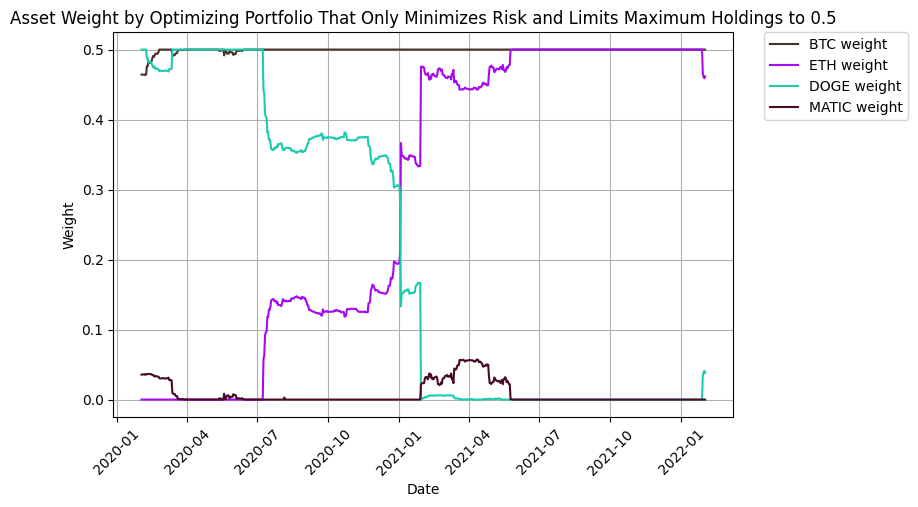

In [60]:
plt.figure(figsize=(8,5))
for col in weights_lim_holdings_df.columns:
    plt.plot(weights_lim_holdings_df[col], c=cmap[col], label=(col+' weight'))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Weight')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Asset Weight by Optimizing Portfolio That Only Minimizes Risk and Limits Maximum Holdings to 0.5')
plt.show()

### Portfolio 2: Only Minimize Risk, Do Not Limit Maximum Holdings

In [61]:
weights_df2 = pd.DataFrame(columns=['BTC', 'ETH', 'DOGE', 'MATIC'])

for i in range(0, len(simple_returns)):
    date = pd.to_datetime(simple_returns.iloc[i].name, format='%Y-%m-%d')
    past_365 = simple_returns.iloc[(i-365):(i)]
    past_365 = deepcopy(past_365)
    if len(past_365) == 365:
        optimal_weights = get_optimized_portfolio(past_365, returns_scale = 0, max_holding=1)
        weights_df2.loc[date] = np.round(optimal_weights, 4)
    else:
        weights_df2.loc[date] = np.NaN   

In [62]:
weights_df2.dropna(inplace=True)
weights_no_lim_holdings_df = deepcopy(weights_df2)
weights_no_lim_holdings_df

,BTC,ETH,DOGE,MATIC
2020-02-02,0.4498,0.0,0.5148,0.0353
2020-02-03,0.4503,0.0,0.5145,0.0352
2020-02-04,0.4503,0.0,0.5143,0.0354
2020-02-05,0.4506,0.0,0.5139,0.0355
2020-02-06,0.4490,0.0,0.5151,0.0359
...,...,...,...,...
2022-01-28,1.0000,0.0,-0.0000,0.0000
2022-01-29,0.9929,-0.0,0.0071,-0.0000
2022-01-30,0.9904,-0.0,0.0096,-0.0000
2022-01-31,0.9897,-0.0,0.0103,-0.0000


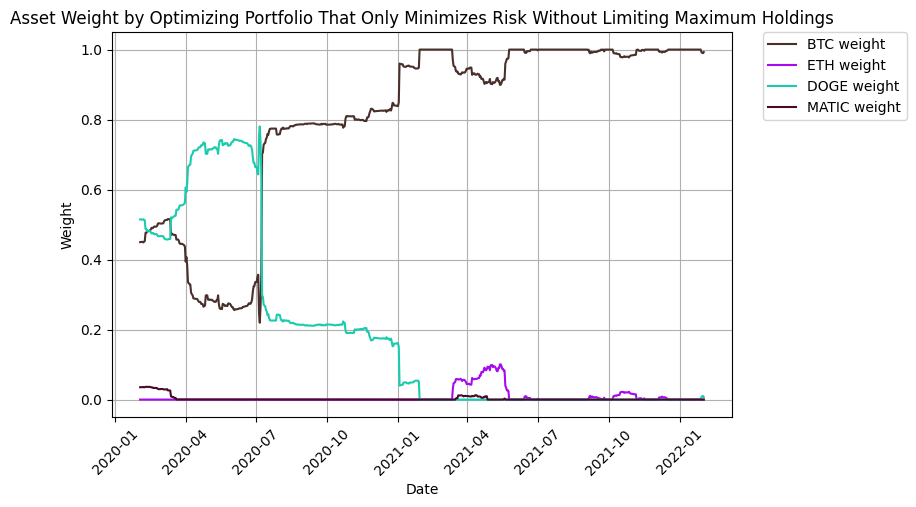

In [63]:
plt.figure(figsize=(8,5))
for col in weights_no_lim_holdings_df.columns:
    plt.plot(weights_no_lim_holdings_df[col], c=cmap[col], label=(col+' weight'))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Weight')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Asset Weight by Optimizing Portfolio That Only Minimizes Risk Without Limiting Maximum Holdings')
plt.show()

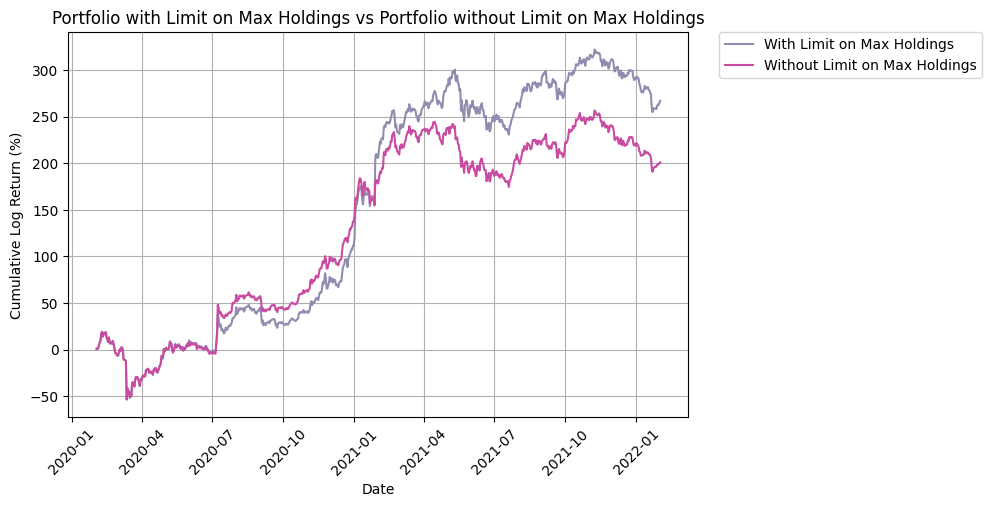

In [64]:
portfolio1 = compute_log_portfolio_returns(simple_returns.loc["2020-02-02":], weights_lim_holdings_df)
portfolio2 = compute_log_portfolio_returns(simple_returns.loc["2020-02-02":], weights_no_lim_holdings_df)
all_portfolio_returns = pd.concat([portfolio1, portfolio2], axis = 1)
all_portfolio_returns.columns = ["With Limit on Max Holdings", "Without Limit on Max Holdings"]

plt.figure(figsize=(8,5))
for col in all_portfolio_returns.columns:
    rgb = np.random.rand(3,)
    plt.plot(all_portfolio_returns[col].expanding(0).apply(lambda x: sum(x) * 100, raw = True), c=rgb, label=(col))

plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Cumulative Log Return (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.title('Portfolio with Limit on Max Holdings vs Portfolio without Limit on Max Holdings')
plt.show()

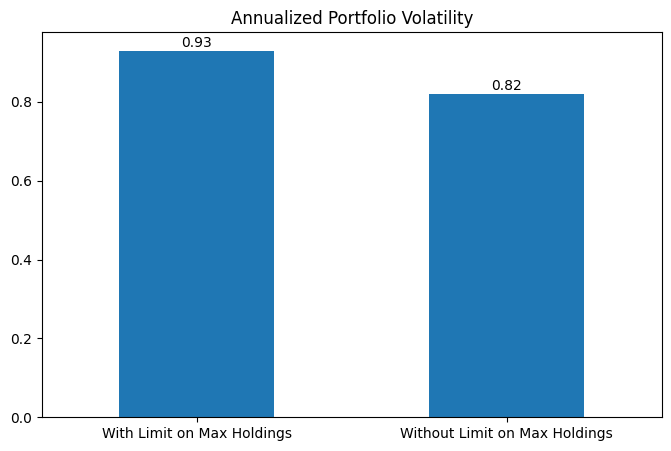

In [65]:
# plot volatility
ax = round(all_portfolio_returns.std(axis = 0) * 365 ** 0.5, 2).plot(kind="bar", figsize = (8, 5))
plt.title("Annualized Portfolio Volatility")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.20, p.get_height() + 0.01))

locs, labels = plt.xticks()
plt.setp(labels, rotation=0)
plt.show()

## Question 3

Similarly, in order to compute the VaR and ES curve, we have to take *previous 1 year's* records, i.e. 365-day records as the length of the rolling window to compute the VaR and ES for today.

We use Historical Simulation method to estimate VaR and ES.

In [66]:
all_simple_return_df = deepcopy(simple_returns)
all_simple_return_df["Portfolio2_return"] = np.exp(portfolio2) - 1
all_simple_return_df.dropna(inplace=True)
all_simple_return_df

,BTC_return,ETH_return,DOGE_return,MATIC_return,Portfolio2_return
Date,,,,,
2020-02-02,-0.005165,0.026915,0.018993,0.042769,0.008964
2020-02-03,-0.005441,0.006614,-0.011345,0.155428,-0.002816
2020-02-04,-0.012112,-0.003236,0.025820,-0.043331,0.006291
2020-02-05,0.047104,0.079152,0.031562,0.014388,0.037956
2020-02-06,0.012106,0.039704,0.027498,0.141184,0.024668
...,...,...,...,...,...
2022-01-28,0.017397,0.051214,0.002896,0.054995,0.017397
2022-01-29,0.009365,0.019627,0.009883,0.009378,0.009369
2022-01-30,-0.005784,0.002457,-0.025060,-0.052883,-0.005969


In [67]:
all_simple_return_df.iloc[:, 2].name

'DOGE_return'

In [68]:
df_VaR_HS = deepcopy(all_simple_return_df)

for i in range(0, len(df_VaR_HS)):
    for j in range(len(all_simple_return_df.columns)):
        past_365 = df_VaR_HS.iloc[(i-365):(i), j]
        past_365.dropna(inplace=True)
        if len(past_365) == 365:
            VaR = past_365.quantile(0.05) # VaR of 95%
            log_returns_sorted = sorted(past_365.dropna())
            length = len(log_returns_sorted)

            cutoff_rt_index = math.floor(length*0.05 +1) - 1
                
            sum_rt = sum(log_returns_sorted[:cutoff_rt_index])

            df_VaR_HS.loc[df_VaR_HS.iloc[i].name, (all_simple_return_df.iloc[:, j].name+'_VaR_95')] = VaR
            df_VaR_HS.loc[df_VaR_HS.iloc[i].name, (all_simple_return_df.iloc[:, j].name+'_ES_95')] = sum_rt/len(log_returns_sorted[:cutoff_rt_index])
        else:
            df_VaR_HS.loc[df_VaR_HS.iloc[i].name, (all_simple_return_df.iloc[:, j].name+'_VaR_95')] = np.NaN
            df_VaR_HS.loc[df_VaR_HS.iloc[i].name, (all_simple_return_df.iloc[:, j].name+'_ES_95')] = np.NaN


In [69]:
df_VaR_HS.dropna(inplace=True)
df_old_HS = deepcopy(df_VaR_HS)
df_VaR_HS = df_VaR_HS.loc["2020-02-01":]
df_VaR_HS

,BTC_return,ETH_return,DOGE_return,MATIC_return,Portfolio2_return,BTC_return_VaR_95,BTC_return_ES_95,ETH_return_VaR_95,ETH_return_ES_95,DOGE_return_VaR_95,DOGE_return_ES_95,MATIC_return_VaR_95,MATIC_return_ES_95,Portfolio2_return_VaR_95,Portfolio2_return_ES_95
Date,,,,,,,,,,,,,,,
2021-02-01,0.012768,0.041106,-0.062399,0.067870,0.012768,-0.049550,-0.089176,-0.070920,-0.121454,-0.068688,-0.133760,-0.087769,-0.157038,-0.048033,-0.085876
2021-02-02,0.058834,0.106756,-0.096201,0.005040,0.058834,-0.049550,-0.089176,-0.070920,-0.121454,-0.068688,-0.133760,-0.087769,-0.157038,-0.048033,-0.085876
2021-02-03,0.055246,0.096170,0.177665,0.067011,0.055246,-0.049550,-0.089176,-0.070920,-0.121454,-0.073270,-0.134976,-0.087769,-0.157038,-0.048033,-0.085876
2021-02-04,-0.014571,-0.039826,0.435587,0.080094,-0.014571,-0.049550,-0.089176,-0.070920,-0.121454,-0.073270,-0.134976,-0.087769,-0.157038,-0.048033,-0.085876
2021-02-05,0.032991,0.077684,-0.119237,0.156715,0.032991,-0.049550,-0.089176,-0.070920,-0.121454,-0.073270,-0.134976,-0.087769,-0.157038,-0.048033,-0.085876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-28,0.017397,0.051214,0.002896,0.054995,0.017397,-0.062097,-0.088348,-0.074278,-0.114894,-0.101621,-0.181972,-0.099330,-0.147848,-0.063396,-0.089000
2022-01-29,0.009365,0.019627,0.009883,0.009378,0.009369,-0.062097,-0.088348,-0.074278,-0.114894,-0.101621,-0.181972,-0.099330,-0.147848,-0.063396,-0.089000
2022-01-30,-0.005784,0.002457,-0.025060,-0.052883,-0.005969,-0.062097,-0.088348,-0.074278,-0.114894,-0.101621,-0.181972,-0.099330,-0.147848,-0.063396,-0.089000


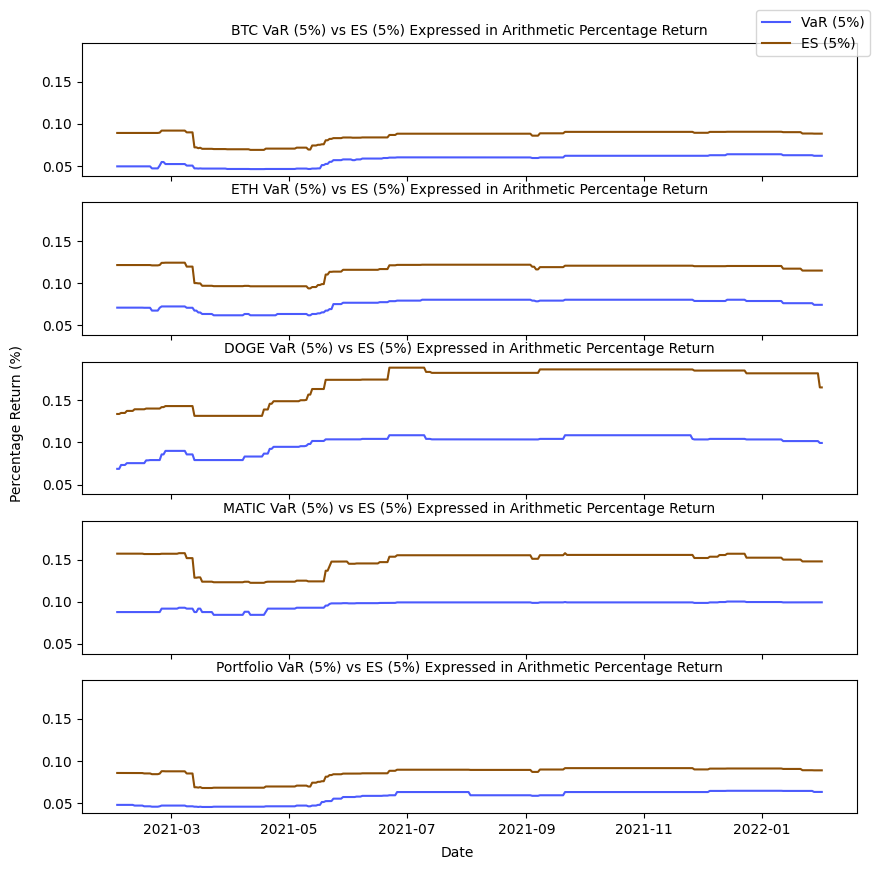

In [90]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 10), sharex=True, sharey=True)
ax1, ax2, ax3, ax4, ax5 = axes.flatten()
var_col = np.random.rand(3,)
es_col = np.random.rand(3,)

var1, = ax1.plot(-df_VaR_HS[tickers[0]+'_VaR_95'], c=var_col)
es1, = ax1.plot(-df_VaR_HS[tickers[0]+'_ES_95'], c=es_col)
ax1.set_title('BTC VaR (5%) vs ES (5%) Expressed in Arithmetic Percentage Return')
ax1.title.set_size(10)

var2, = ax2.plot(-df_VaR_HS[tickers[1]+'_VaR_95'], c=var_col)
es2, = ax2.plot(-df_VaR_HS[tickers[1]+'_ES_95'], c=es_col)
ax2.set_title('ETH VaR (5%) vs ES (5%) Expressed in Arithmetic Percentage Return')
ax2.title.set_size(10)

var3, = ax3.plot(-df_VaR_HS[tickers[2]+'_VaR_95'], c=var_col)
es3, = ax3.plot(-df_VaR_HS[tickers[2]+'_ES_95'], c=es_col)
ax3.set_title('DOGE VaR (5%) vs ES (5%) Expressed in Arithmetic Percentage Return')
ax3.title.set_size(10)

var4, = ax4.plot(-df_VaR_HS[tickers[3]+'_VaR_95'], c=var_col)
es4, = ax4.plot(-df_VaR_HS[tickers[3]+'_ES_95'], c=es_col)
ax4.set_title('MATIC VaR (5%) vs ES (5%) Expressed in Arithmetic Percentage Return')
ax4.title.set_size(10)

var5, = ax5.plot(-df_VaR_HS[tickers[4]+'_VaR_95'], c=var_col)
es5, = ax5.plot(-df_VaR_HS[tickers[4]+'_ES_95'], c=es_col)
ax5.set_title('Portfolio VaR (5%) vs ES (5%) Expressed in Arithmetic Percentage Return')
ax5.title.set_size(10)

fig.legend((var5, es5), ('VaR (5%)', 'ES (5%)'), loc='upper right', bbox_to_anchor=[0.92, 0.92])

# Set common labels
fig.text(0.5, 0.07, 'Date', ha='center', va='center')
fig.text(0.06, 0.5, 'Percentage Return (%)', ha='center', va='center', rotation='vertical')

plt.show()
